In [1]:
from src.statespace import RWModel, CVModel, CAModel, StateSpace
from src.trajectory import Trajectory
from src.kalmanfilter import KalmanFilter
from src.auxil import rmse, plot_estimates, plot_rmse, plot_traj
from src.kfnet import KFNet

import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

# sns.set()
sns.set_style("white")
# plt.style.use('seaborn-poster')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
RANDOM_SEED = None
ndat = 500
q = 9.5e-5          # Process noise intensity
r = 1.3             # Observation noise std
c_rwm = 10          # RWM process noise scaling constant
expf = 0.95         # Exponential forgetting param
reset_thresh = 10.0  # Filter reset threshold (Euclidean distance from centroid)
init_state = np.zeros(6)

In [4]:
KFN_SEED = 5

kfsr = [
    KalmanFilter(RWModel(c_rwm*q, r), lambda_expf=expf),
    KalmanFilter(RWModel(c_rwm*q, r), lambda_expf=expf),    
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CAModel(q, r)),
    KalmanFilter(CAModel(q, r)),
    KalmanFilter(CAModel(q, r)),
]
np.random.seed(KFN_SEED)
np.random.shuffle(kfsr)
# lbls = ["RWM", "CVM", "CAM"]
# lbls = {n:lbl for n, lbl  in enumerate(lbls)}

kfnr = KFNet(10, 7, init=kfsr, random_seed=KFN_SEED)
np.random.seed()
kfnr.generate_txt_labels()
# kfn.draw_network()

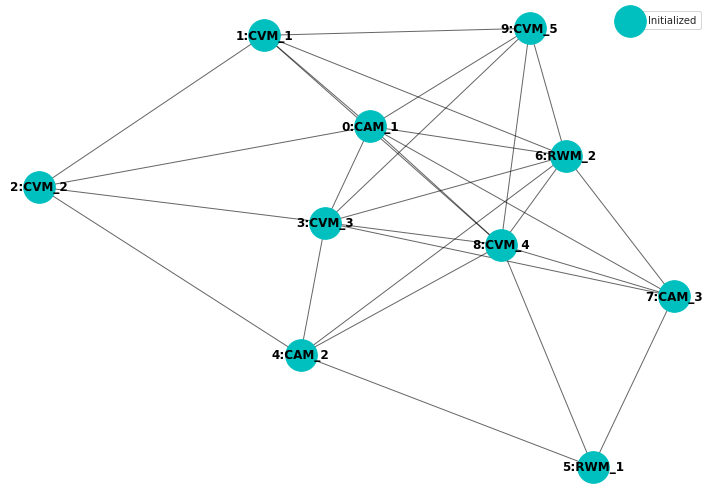

In [5]:
KFN_SEED = 5

kfs = [
    KalmanFilter(RWModel(c_rwm*q, r), lambda_expf=expf),
    KalmanFilter(RWModel(c_rwm*q, r), lambda_expf=expf),    
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CAModel(q, r)),
    KalmanFilter(CAModel(q, r)),
    KalmanFilter(CAModel(q, r)),
]
np.random.seed(KFN_SEED)
np.random.shuffle(kfs)
# lbls = ["RWM", "CVM", "CAM"]
# lbls = {n:lbl for n, lbl  in enumerate(lbls)}

kfn = KFNet(10, 7, init=kfs, random_seed=KFN_SEED)
np.random.seed()
kfn.generate_txt_labels()
kfn.draw_network()

In [6]:
# Trajectory simulator initialization
R = kfn.observation_covs()

traj = Trajectory(
            CAModel(q, r),
            n_steps=ndat,
            init_state=init_state,
            R=R,
            random_seed=None
)

In [7]:
for yt in traj.observations:
#     kfn.time_step(
#         yt,
#         predict=True,
#         update=True,
#         adapt=True,
#         combine=True,
#         reset_strategy="mean",
#         reset_thresh=reset_thresh,
#         c=3.0
#     )
    
    kfn.predict()
#     kfn.reset_filters(reset_strategy="mean", reset_thresh=reset_thresh, c=1.0)
    kfn.update(yt)
    kfn.adapt()
    kfn.combine()
    kfn.log()
    
    kfnr.reset_filters(reset_strategy="ci", reset_thresh=reset_thresh, c=1.0)
    kfnr.predict()
    kfnr.update(yt)
    kfnr.adapt()
#     kfnr.combine()
    kfnr.log()

In [8]:
RWM = kfn[6]
CVM = kfn[3]
CAM = kfn[7]

In [9]:
kfcam = KalmanFilter(CAModel(q, r))

for yt in traj.observations[:, 0]:
    kfcam.predict()
    kfcam.update(yt, log=True)

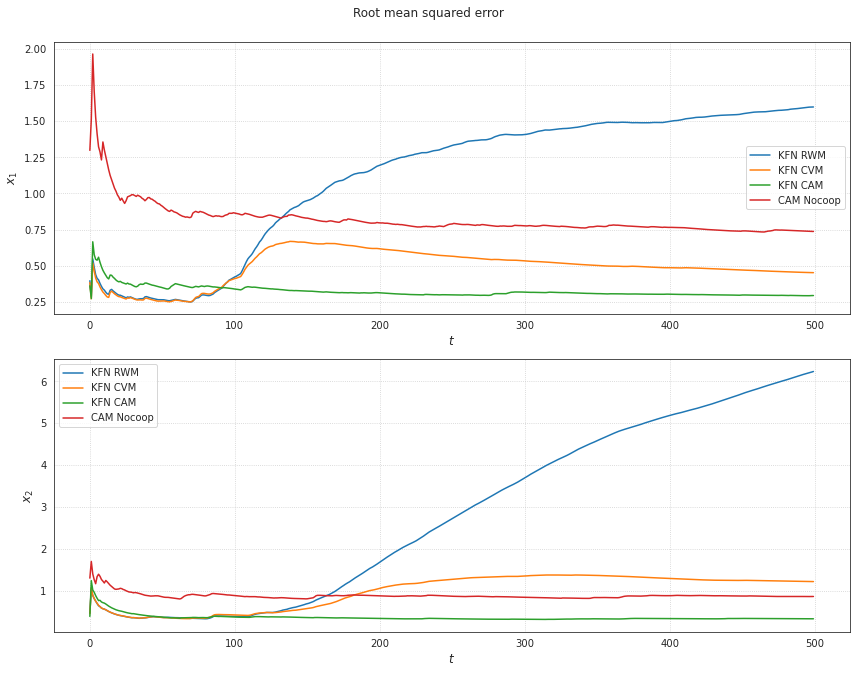

In [10]:
plot_rmse(traj, RWM, CVM, CAM, kfcam, nvars=2, var_labels=["$x_1$", "$x_2$"], kf_labels=["KFN RWM", "KFN CVM", "KFN CAM", "CAM Nocoop"])

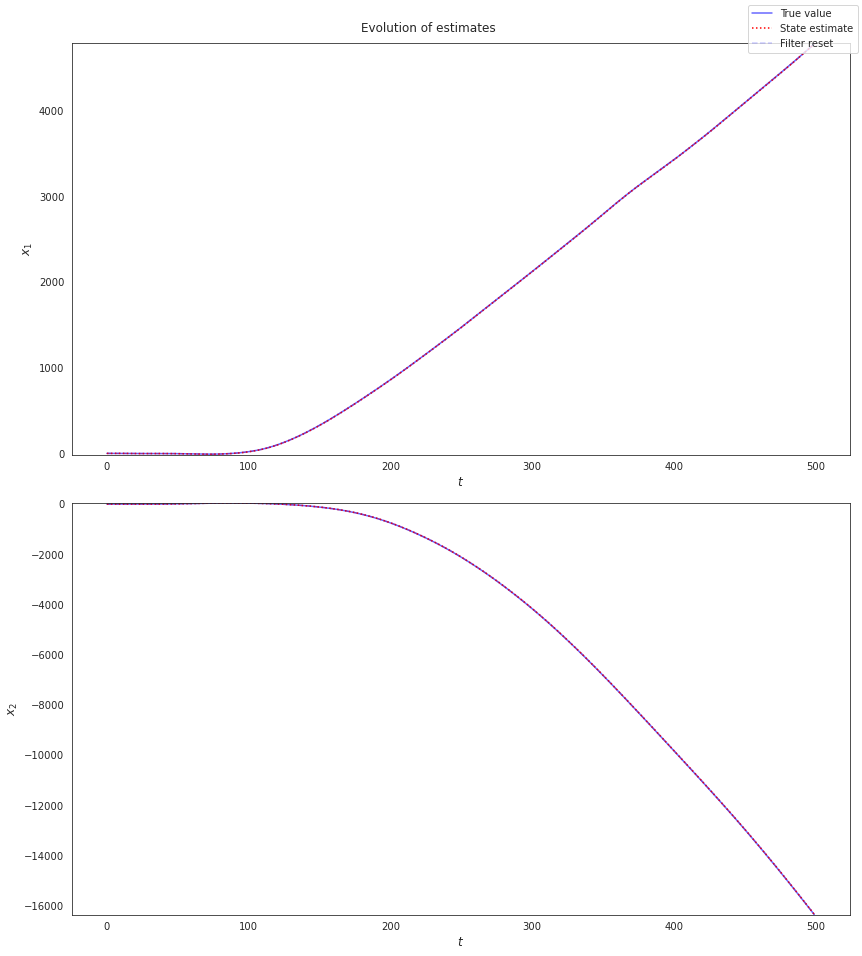

In [11]:
plot_estimates(RWM, traj, nvars=2, plt_std=True, labels=["$x_1$", "$x_2$"])

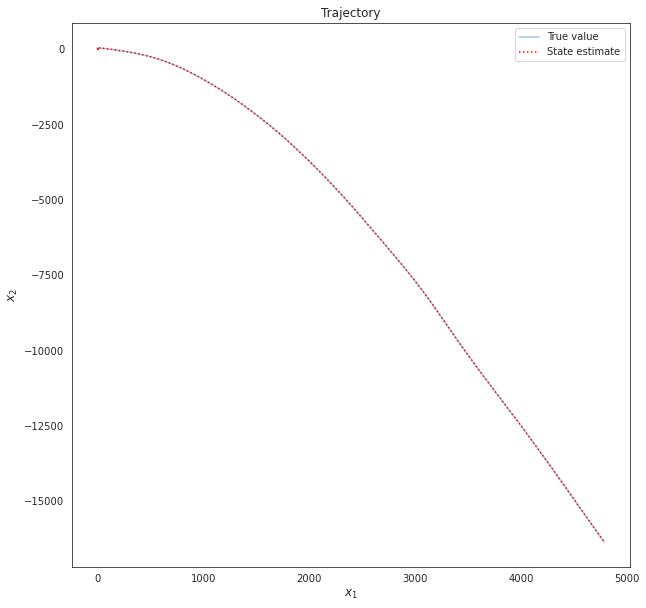

In [12]:
plot_traj(traj, kf=RWM)

In [13]:
import pickle

filename = "traj.pkl"
with open(filename, "wb") as f:
    pickle.dump(obj=traj, file=f)

In [14]:
filename = "rwm.pkl"
with open(filename, "wb") as f:
    pickle.dump(obj=RWM, file=f)

In [15]:
RWM_kfn = kfn[6]
RWM_kfnr = kfnr[6]

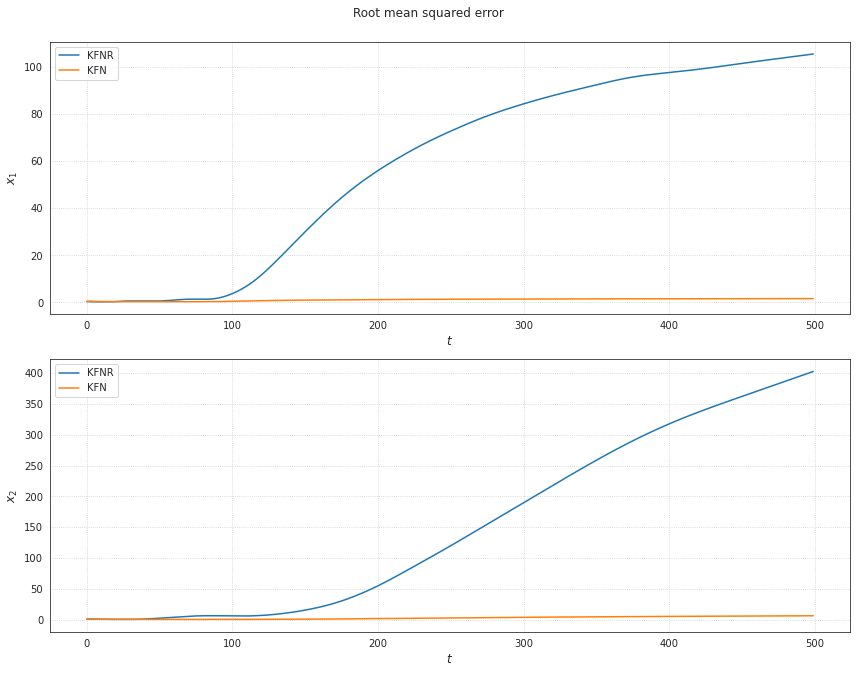

In [16]:
plot_rmse(traj, RWM_kfnr, RWM_kfn, nvars=2, var_labels=["$x_1$", "$x_2$"], kf_labels=["KFNR", "KFN"])

In [17]:
print(len(RWM_kfnr._reset_log))
print(len(RWM_kfn._reset_log))

0
0


In [18]:
np.allclose(RWM_kfnr.history, RWM_kfn.history, rtol=1e-4, atol=1e-4)

False

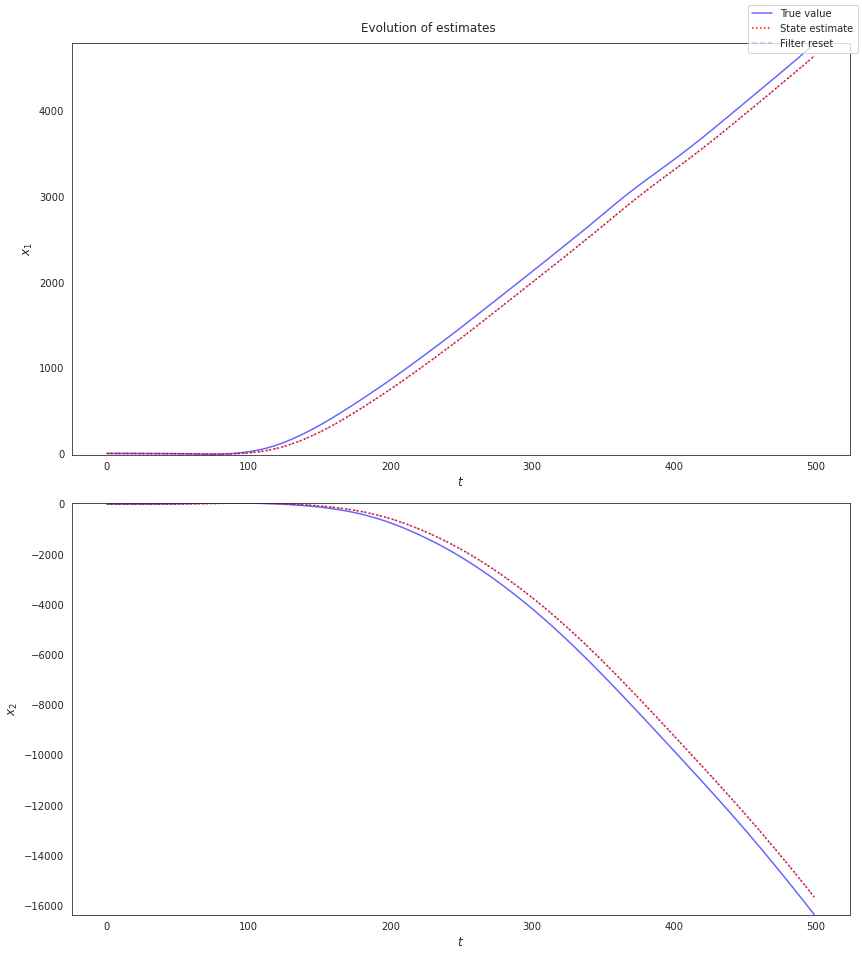

In [19]:
plot_estimates(RWM_kfnr, traj, nvars=2, plt_std=True, labels=["$x_1$", "$x_2$"])